In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import glob
import re

from skimage import measure, morphology
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.segmentation import clear_border
from skimage.filters import roberts, sobel

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '/kaggle_3/stage2/'
OUTPUT_FOLDER = '/kaggle_3/stage2_processed/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

### Load scans

In [2]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

### Pixel distribution histogram

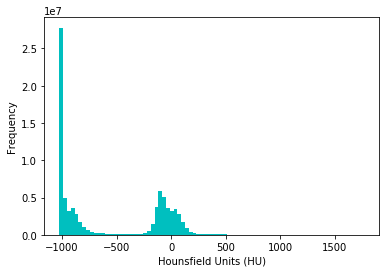

In [4]:
# Show pixel distribution
random_patient_index = int(np.random.random() * len(patients))
# random_patient = load_scan(INPUT_FOLDER + '39c3a2d2ca67bc7a1a22240ea571d50c')
random_patient = load_scan(INPUT_FOLDER + patients[random_patient_index])
random_patient_pixels = get_pixels_hu(random_patient)
plt.hist(random_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

### Plot random slice

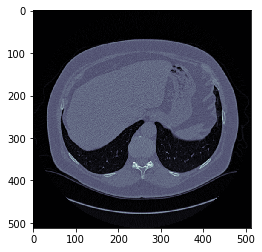

In [5]:
def plot_2d(im):
    # Show some slice in the middle
    plt.imshow(im, cmap=plt.cm.bone)
    plt.show()

# Show some slice in the middle
random_slice_index = int(np.random.random() * len(random_patient))
plot_2d(random_patient_pixels[random_slice_index])

In [6]:
print(random_patient[0].PatientID)

5df13e26655687c40cfb724cffc27255


### Resampling

In [6]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    # print(spacing)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    # print(real_resize_factor)
    if (real_resize_factor[0] == 0.0):
        real_resize_factor[0] = 1.0
    image = ndi.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [7]:
pix_resampled, spacing = resample(random_patient_pixels, random_patient, [1,1,1])
print("Shape before resampling\t", random_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (315, 512, 512)
Shape after resampling	 (315, 400, 400)


### 3D Plot

In [8]:
def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

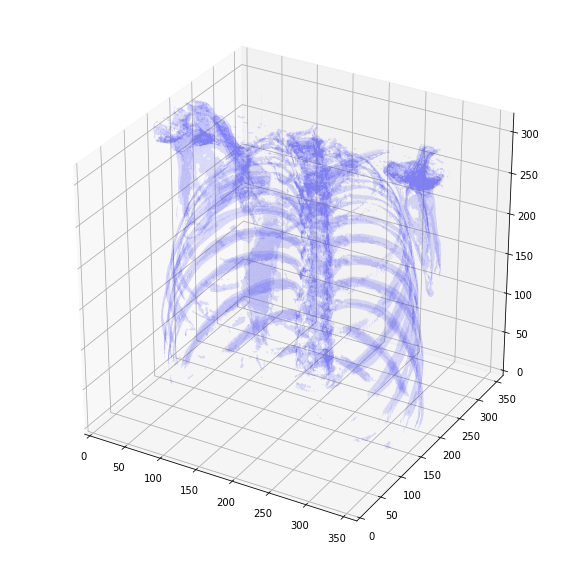

In [213]:
plot_3d(pix_resampled, 400)

In [9]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [219]:
def segment_lung_mask_v2(imgs):
    masks = []
    for im in imgs:
    
        '''
        This funtion segments the lungs from the given 2D slice.
        Step 1: Convert into a binary image. 
        '''
        binary = im < 604
        '''
        Step 2: Remove the blobs connected to the border of the image.
        '''
        cleared = clear_border(binary)
        '''
        Step 3: Label the image.
        '''
        label_image = label(cleared)
        '''
        Step 4: Keep the labels with 2 largest areas.
        '''
        areas = [r.area for r in regionprops(label_image)]
        areas.sort()
        if len(areas) > 2:
            for region in regionprops(label_image):
                if region.area < areas[-2]:
                    for coordinates in region.coords:                
                           label_image[coordinates[0], coordinates[1]] = 0
        binary = label_image > 0
        '''
        Step 5: Erosion operation with a disk of radius 2. This operation is 
        seperate the lung nodules attached to the blood vessels.
        '''
        selem = disk(2)
        binary = binary_erosion(binary, selem)
        '''
        Step 6: Closure operation with a disk of radius 10. This operation is 
        to keep nodules attached to the lung wall.
        '''
        selem = disk(10)
        binary = binary_closing(binary, selem)
        '''
        Step 7: Fill in the small holes inside the binary mask of lungs.
        '''
        edges = roberts(binary)
        binary = ndi.binary_fill_holes(edges)
        
        masks.append(binary)
    return np.asarray(masks)

### Lung segmentation
Lung segmentation done 3 ways.

In [220]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
segmented_lungs_v2 = segment_lung_mask_v2(pix_resampled)

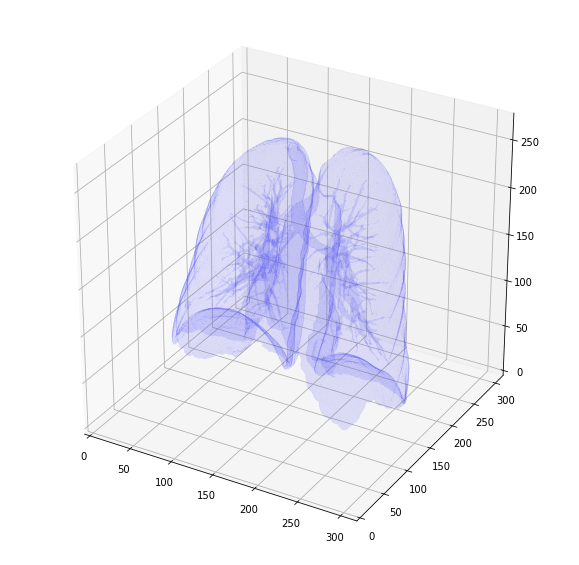

In [221]:
plot_3d(segmented_lungs, 0)

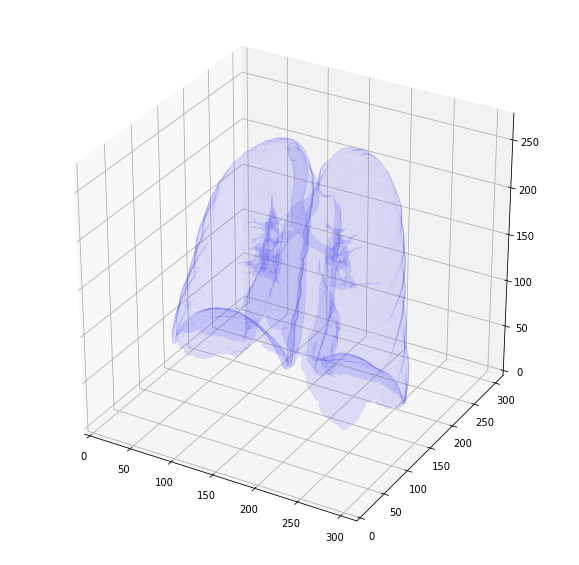

In [222]:
plot_3d(segmented_lungs_fill, 0)

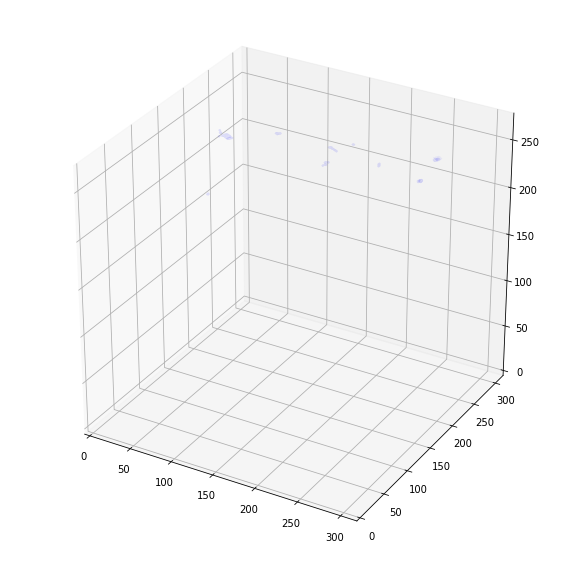

In [224]:
plot_3d(segmented_lungs_v2, 0)

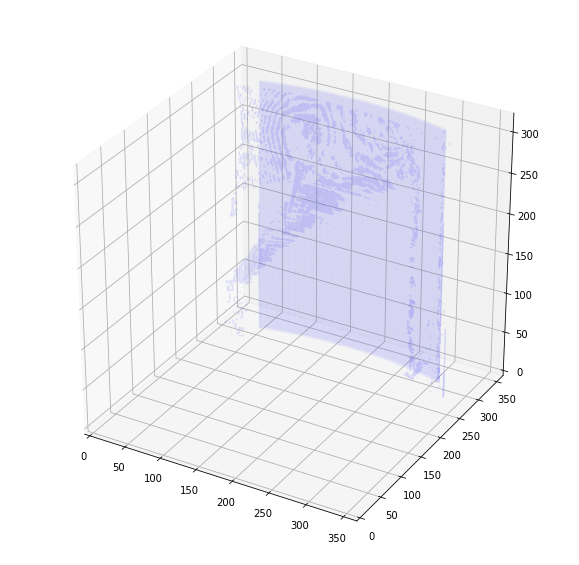

In [211]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

### Plot random slice with masks applied

segmented_lungs


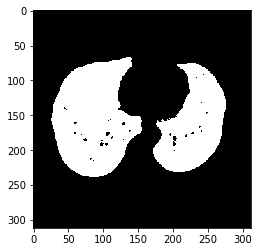

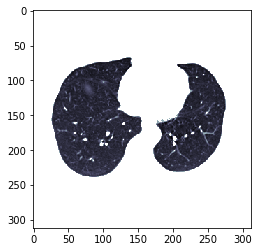

segmented_lungs_fill


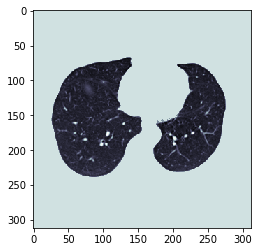

segmented_lungs_v2


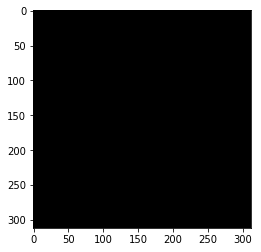

segmented_lungs_fill - segmented_lungs


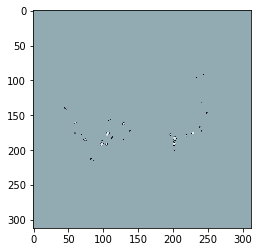

segmented_lungs_v2 - segmented_lungs


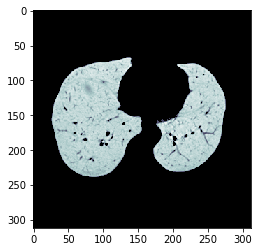

segmented_lungs_v2 - segmented_lungs_fill


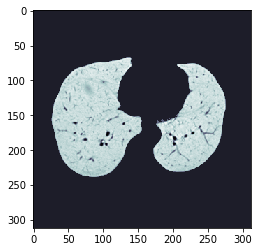

In [230]:
print('segmented_lungs')
plot_2d(segmented_lungs[random_slice_index])

plot_2d(np.multiply(pix_resampled[random_slice_index], segmented_lungs[random_slice_index]))
print('segmented_lungs_fill')
plot_2d(np.multiply(pix_resampled[random_slice_index], segmented_lungs_fill[random_slice_index]))
print('segmented_lungs_v2')
plot_2d(np.multiply(pix_resampled[random_slice_index], segmented_lungs_v2[random_slice_index]))
print('segmented_lungs_fill - segmented_lungs')
plot_2d(np.multiply(pix_resampled[random_slice_index], segmented_lungs_fill[random_slice_index] - segmented_lungs[random_slice_index]))
print('segmented_lungs_v2 - segmented_lungs')
plot_2d(np.multiply(pix_resampled[random_slice_index], segmented_lungs_v2[random_slice_index] - segmented_lungs[random_slice_index]))
print('segmented_lungs_v2 - segmented_lungs_fill')
plot_2d(np.multiply(pix_resampled[random_slice_index], segmented_lungs_v2[random_slice_index] - segmented_lungs_fill[random_slice_index]))


### Run segmentation for all patients

In [11]:
patients_processed_files = glob.glob(OUTPUT_FOLDER + 'segment_lungs_fill_*.npy')
patients_processed = set()
for filename in patients_processed_files:
    m = re.match(r'segment_lungs_fill_([a-f0-9].*).npy', os.path.basename(filename))
    patients_processed.add(m.group(1))
    
print('Already processed ' + str(len(patients_processed)) + '/' + str(len(patients)) + ' patients')

Already processed 0/506 patients


In [ ]:
patient_count = 1
for patient in patients:
    if patient in patients_processed:
        print('Skipping already processed patient ' + patient)
        continue
    print('Processing patient' + patient)
    patient_scans = load_scan(INPUT_FOLDER + patient)
    patient_pixels = get_pixels_hu(patient_scans)
    print('Resample ' + patient)
    pix_resampled, spacing = resample(patient_pixels, patient_scans, [1,1,1])
    print('Segment ' + patient)
    segmented_lungs = segment_lung_mask(pix_resampled, False)
    print('Segment fill ' + patient)
    
    segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
    
    np.save(OUTPUT_FOLDER + "segmented_lungs_%s.npy" % (patient), segmented_lungs)
    np.save(OUTPUT_FOLDER + "segmented_lungs_fill_%s.npy" % (patient), segmented_lungs_fill)
    print('Processed ', patient_count, ' patients')
    patient_count+=1

### Apply masks on input images

In [ ]:
%%time

patients_processed_files = glob.glob(OUTPUT_FOLDER + 'scan_segmented_lungs_*.npy')
patients_processed = set()
for filename in patients_processed_files:
    m = re.match(r'scan_segmented_lungs_([a-f0-9].*).npy', os.path.basename(filename))
    patients_processed.add(m.group(1))
    
print('Already processed ' + str(len(patients_processed)) + '/' + str(len(patients)) + ' patients')

patient_count = 1
for patient_id in patients:
    if patient_id in patients_processed:
        print('Skipping already processed patient ' + patient_id)
        continue
    patient = load_scan(INPUT_FOLDER + patient_id)
    patient_pixels = get_pixels_hu(patient)
    pix_resampled, spacing = resample(patient_pixels, patient, [1,1,1])
    segmented_lungs_mask = segment_lung_mask(pix_resampled, False)
    segmented_lungs_fill_mask = segment_lung_mask(pix_resampled, True)
    scan_segmented_lungs = np.multiply(pix_resampled, segmented_lungs_mask)
    scan_segmented_lungs_fill = np.multiply(pix_resampled, segmented_lungs_fill_mask)
    np.save(OUTPUT_FOLDER + "scan_segmented_lungs_%s.npy" % (patient_id), scan_segmented_lungs)
    np.save(OUTPUT_FOLDER + "scan_segmented_lungs_fill_%s.npy" % (patient_id), scan_segmented_lungs_fill)
    print('Processed ', patient_count, ' patients')
    patient_count+=1

Already processed 0/506 patients
